# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
from e2 import CacheEnv

In [81]:
# env vars
EPS_LEN = 100
# EPS_LEN = 500
N_PAGES = 20
CACHE_LIMIT = 10 

env = CacheEnv(
        eps_len=EPS_LEN, 
        n_pages=N_PAGES, 
        limit=CACHE_LIMIT
        )

# dqn vars
# N_EPS = 60000
N_EPS = 5000
BATCH_SIZE = 32
LR_adam = 3e-3                   # learning rate for Adam (use adam, sgd is slow even though more "stable")
LR_sgd = 5e-1                   # learning rate for SGD (pretty high, determined using other notebook)
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 2000   # target update frequency
MEMORY_CAPACITY = 20000

s = env.reset()
N_ACTIONS = env.action_space_n
STATE_SHAPE = (CACHE_LIMIT, 2)
N_STATES = STATE_SHAPE[0]*STATE_SHAPE[1]

Cache limit: 10
Total Pages: 20


In [82]:
print(N_ACTIONS)
print(N_STATES)

10
20


In [83]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        input_size = N_STATES
        h_dim = 80
#         h_dim = 30
        self.fc1 = nn.Linear(input_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim//4)
        self.fc3 = nn.Linear(h_dim//4, h_dim)
        self.out = nn.Linear(h_dim, N_ACTIONS)

    def forward(self, x):
#         bs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [84]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net().cuda(), Net().cuda()
        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR_adam)
#         self.optimizer = torch.optim.SGD(self.eval_net.parameters(), lr=LR_sgd)
        self.loss_func = nn.MSELoss()
        self.PATH = 'model/'

    def choose_action(self, x):
#         x = torch.unsqueeze(torch.FloatTensor(x), 0).cuda()
        x = torch.FloatTensor(x).cuda()
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net(x).detach().cpu()
            action = torch.argmax(actions_value).data.numpy()
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES]).cuda()
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int)).cuda()
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2]).cuda()
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:]).cuda()

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1) 
#         q_eval = self.eval_net(b_s)  # shape (batch, 1) 
        
        q_next = self.target_net(b_s_).detach()   # detach from graph, don't backpropagate
#         q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        q_target = b_r + GAMMA * q_next.argmax(dim=1).view(BATCH_SIZE, 1)   # shape (batch, 1)
        
        self.q_target = q_target
        self.q_eval = q_eval
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def save_model(self, eval_name = 'eval_net', train_name = 'train_net'):
        torch.save(self.eval_net.state_dict(), self.PATH  + str(N_STATES) + eval_name)
        torch.save(self.target_net.state_dict(), self.PATH  + str(N_STATES)+ train_name)
        
    def load_model(self, eval_name = 'eval_net.m', train_name = 'train_net.m'):
        self.eval_net.load_state_dict(torch.load(self.PATH +  str(N_STATES) + eval_name))
        self.target_net.load_state_dict(torch.load(self.PATH  + str(N_STATES) + train_name))

In [85]:
start = time.time()
dqn = DQN()
# dqn.load_model()
print("Start")
print('\nCollecting experience...')
history = []
for i_episode in range(N_EPS):
    s = env.reset()
    ep_r = 0
    n = 0
    while True:
        a = dqn.choose_action(s)
        s_, r, done, info = env.step(a)
        dqn.store_transition(s, a, r, s_)
        ep_r += r
        n += 1
        
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
        
        if done:
            history.append(ep_r)
            if (dqn.memory_counter > MEMORY_CAPACITY) and i_episode%100==0:
                print('Ep: ', i_episode, '| Ep_r: ', ep_r, f'Ran for: {n} timesteps')
            break

        s = s_
end = time.time()

Start

Ep:  200 | Ep_r:  75 Ran for: 100 timesteps
Ep:  300 | Ep_r:  127 Ran for: 100 timesteps
Ep:  400 | Ep_r:  160 Ran for: 100 timesteps
Ep:  500 | Ep_r:  214 Ran for: 100 timesteps
Ep:  600 | Ep_r:  133 Ran for: 100 timesteps
Ep:  700 | Ep_r:  227 Ran for: 100 timesteps
Ep:  800 | Ep_r:  118 Ran for: 100 timesteps
Ep:  900 | Ep_r:  194 Ran for: 100 timesteps
Ep:  1000 | Ep_r:  88 Ran for: 100 timesteps
Ep:  1100 | Ep_r:  147 Ran for: 100 timesteps
Ep:  1200 | Ep_r:  173 Ran for: 100 timesteps
Ep:  1300 | Ep_r:  103 Ran for: 100 timesteps
Ep:  1400 | Ep_r:  99 Ran for: 100 timesteps
Ep:  1500 | Ep_r:  118 Ran for: 100 timesteps
Ep:  1600 | Ep_r:  108 Ran for: 100 timesteps
Ep:  1700 | Ep_r:  121 Ran for: 100 timesteps
Ep:  1800 | Ep_r:  109 Ran for: 100 timesteps
Ep:  1900 | Ep_r:  123 Ran for: 100 timesteps
Ep:  2000 | Ep_r:  152 Ran for: 100 timesteps
Ep:  2100 | Ep_r:  134 Ran for: 100 timesteps
Ep:  2200 | Ep_r:  148 Ran for: 100 timesteps
Ep:  2300 | Ep_r:  172 Ran for: 100 ti

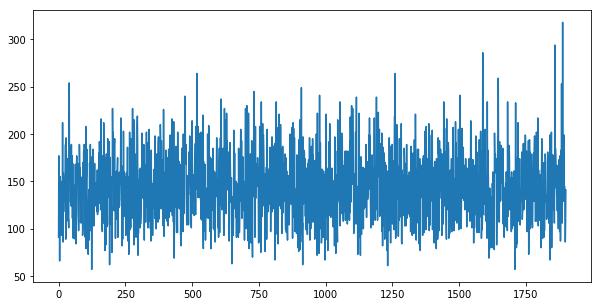

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history[:1900])
plt.show()

# Debugging

In [88]:
# Debugggging
print(dqn.q_eval.shape)
print(dqn.q_target.shape)

torch.Size([32, 1])
torch.Size([32, 1])


In [89]:
def pretty_print(s):
    for i, x in enumerate(s):
        if i == len(s)-1:
            end = '\n'
        elif i%2 == 0:
            end = '-'
        else:
            end = ', ' 
        print(x, end=end)

In [168]:
# s = env.reset()
a = dqn.choose_action(s)
pretty_print(s)
print(f"Chosen action: {a}")
s, r, done, info = env.step(a)
pretty_print(s)
state = torch.Tensor(s).cuda()
out1 = dqn.target_net(state).cpu().detach().numpy()
out2 = dqn.eval_net(state).cpu().detach().numpy()
print(out1)
print(out2)

print(out1.argmax())
print(out2.argmax())

0.007936507936507936-0.011904761904761904, 0.05952380952380952-0.023809523809523808, 0.003968253968253968-0.023809523809523808, 0.011904761904761904-0.015873015873015872, 0.1388888888888889-0.007936507936507936, 0.05555555555555555-0.007936507936507936, 0.21428571428571427-0.003968253968253968, 0.12698412698412698-0.007936507936507936, 0.11507936507936507-0.007936507936507936, 0.14285714285714285-0.011904761904761904
Chosen action: 0
0.015810276679841896-0.015810276679841896, 0.07509881422924901-0.023715415019762844, 0.003952569169960474-0.03162055335968379, 0.02766798418972332-0.015810276679841896, 0.007905138339920948-0.011857707509881422, 0.07114624505928854-0.007905138339920948, 0.22924901185770752-0.003952569169960474, 0.1422924901185771-0.007905138339920948, 0.13043478260869565-0.007905138339920948, 0.15810276679841898-0.011857707509881422
[4.1451    3.8494682 4.147919  4.1718383 4.057754  3.9412909 3.8782973
 4.0805445 4.128989  4.146458 ]
[4.199802  3.9082808 4.0870514 4.192143

In [ ]:
6-2, 10-1, 2-2, 10-1, 10-1, 10-1, 4-3, 1-2, 10-1, 3-1

In [ ]:
net = Net().cuda()
out = net(state)
print(out)

In [ ]:
out.max(dim=0)

In [ ]:
lst = [1, 2, 3, 4, 5, 6]
lst[::2]

In [38]:
s

array([0.06944444, 0.16666667, 0.01388889, 0.15277778, 0.04166667,
       0.18055556, 0.19444444, 0.125     , 0.02777778, 0.02777778])

In [43]:
lru = s[::2]
lfu = s[1::2]
print(lru)
print(lfu)
lru.argmin()
lfu.argmin()

[0.06944444 0.01388889 0.04166667 0.19444444 0.02777778]
[0.16666667 0.15277778 0.18055556 0.125      0.02777778]


4

# Compare with LRU and LFU

In [117]:
from tqdm import tqdm_notebook as tqdm

def choose_action(s, agent):
    if agent == 'dqn':
        return dqn.choose_action(s) 
    if agent == 'lru':
        return s[::2].argmin()
    else:
        return s[1::2].argmin()
    
    
ntests = 1000
performance = {}

for agent in "dqn lru lfu".split():
    for i in tqdm(range(ntests)):
        s = env.reset()
        nhits = 0
        while True:
            a = choose_action(s, agent)
            s_, r, done, info = env.step(a)
            nhits += r

            if done:
                history.append(nhits)
                break
            s = s_
    performance[agent] = np.array(history).mean()      


In [118]:
performance

{'dqn': 140.24616666666665, 'lru': 135.328, 'lfu': 152.493125}